In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = os.getcwd()
print(dir)

/content


In [6]:
from google.colab import drive

WORK_DRIVE = '/content/drive'
WORK_AREA = WORK_DRIVE + '/MyDrive/Car-Damage-Classification-main'

drive.mount(WORK_DRIVE,force_remount=True)

Mounted at /content/drive


In [7]:
os.chdir(WORK_AREA)

In [8]:
os.listdir()

['Car-Damage-Classification-main',
 'car-damage-dataset',
 'models web app',
 'data',
 'data_augmentation_1',
 'data_augmentation_2',
 'vgg19']

## Importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import random
from tqdm import tqdm
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Sequential, Model, load_model

## Importing Saved models

In [10]:
Stage_1_model = load_model('vgg19/vgg19_stage1_fc-0.907.hdf5')
Stage_2_model = load_model('vgg19/vgg19_stage2_fc-0.626.hdf5')
Stage_3_model = load_model('vgg19/vgg19_stage3_fc-0.573.hdf5')

## Importing Darknet git

In [11]:
!/usr/local/cuda/bin/nvcc --version
# Check if GPU is selected as hardware accelerator
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if not '/device:GPU:0' in device_name:
    print('\nERROR: GPU is not selected as hardware accelerator!')
else:
    print(device_name)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
/device:GPU:0


In [12]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!ls
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!make

Cloning into 'darknet'...
remote: Enumerating objects: 15494, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15494 (delta 0), reused 2 (delta 0), pack-reused 15490
Receiving objects: 100% (15494/15494), 14.11 MiB | 8.03 MiB/s, done.
Resolving deltas: 100% (10409/10409), done.
Checking out files: 100% (2057/2057), done.
/content/drive/MyDrive/Car-Damage-Classification-main/darknet
3rdparty		darknet_video.py       net_cam_v4.sh
build			data		       README.md
build.ps1		image_yolov3.sh        results
cfg			image_yolov4.sh        scripts
cmake			include		       src
CMakeLists.txt		json_mjpeg_streams.sh  vcpkg.json
DarknetConfig.cmake.in	LICENSE		       video_yolov3.sh
darknet_images.py	Makefile	       video_yolov4.sh
darknet.py		net_cam_v3.sh
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv`

## Generating report for a given Image

In [13]:
#Creating a single function which predicts wether Car is damaged or not and localizing the damage, severity of damage for a single img
def report(img_path):
    report_pred = []
    #Creating Train and test txt files:
    test_file = open('/content/test.txt','w')
    test_file.write('/content/'+img_path+'\n')
    test_file.close()
    
    img = load_img('/content/'+img_path,target_size = (256,256))
    #Converting into array
    img_arr = img_to_array(img)
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    
    #Checking if Damaged or not
    s1_pred = Stage_1_model.predict(img_arr)
    if s1_pred <=0.5:
        report_pred.append('Damaged')
    else:
        report_pred.append('Not Damaged')
        print('Are you sure the vehicle is Damaged. Please upload another image?')
        return
    #Checking for Damage Localization
    s2_pred = Stage_2_model.predict(img_arr)
    n = np.argmax(s2_pred)
    if n == 0:
        report_pred.append('Front')
    elif n ==1:
        report_pred.append('Rear')
    else:
        report_pred.append('Side')
    
    #Checking for Damage Severity
    s3_pred = Stage_3_model.predict(img_arr)
    c = np.argmax(s3_pred)
    if c == 0:
        report_pred.append('Minor')
    elif c ==1:
        report_pred.append('Moderate')
    elif c==2:
        report_pred.append('Severe')

    image_path = '/content/'+img_path
        
    #Using YOLO to detect the damage type
    temp = !./darknet detector test /content/YOLO/custom.data /content/YOLO/yolov3_custom.cfg /content/models_weights/yolov3_custom_4000.weights -dont_show </content/test.txt> result.txt

    #Final report
    print('The Car is '+report_pred[0]+' on the '+report_pred[1]+' suffering '+report_pred[2]+' damages.')

    %matplotlib inline
    image = cv2.imread('predictions.jpg')
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [42]:
img_name = 'drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data3a/validation/03-severe/0006.JPEG'

The Car is Damaged on the Front suffering Moderate damages.


error: ignored

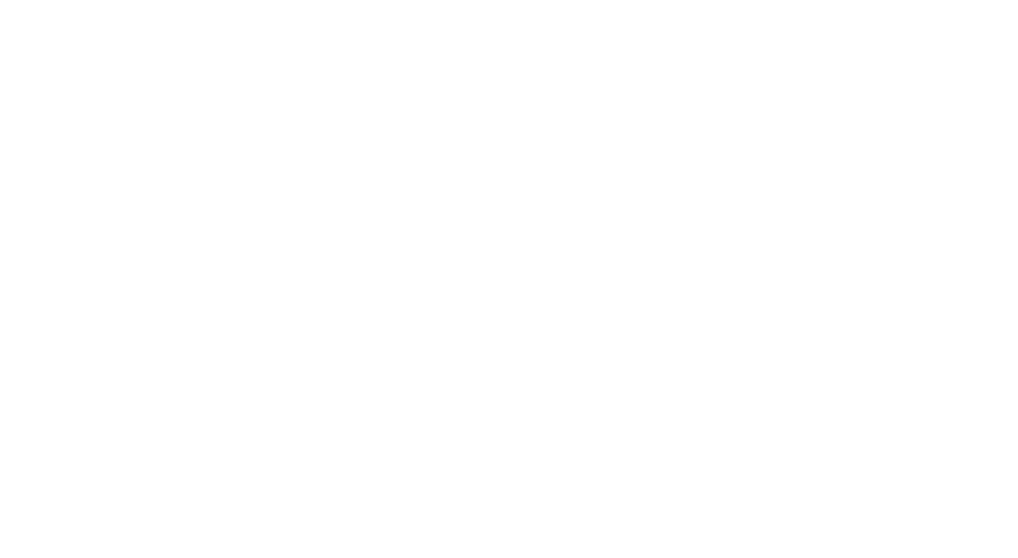

In [43]:
report(img_name)